<a href="https://colab.research.google.com/github/rkambai/trash_classifier/blob/main/trash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/SUTD/")

In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory

import PIL.Image as Image

import matplotlib.pyplot as plt


In [ ]:
def plot_the_loss_curve(epochs, loss):
    """Plot a curve of loss vs. epoch."""

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.plot(epochs, loss, label="Loss")
    plt.legend()
    plt.ylim([loss.min()*0.95, loss.max() * 1.05])
    plt.show()  

In [ ]:
data_dir = '/content/drive/MyDrive/SUTD/dataset-resized'

IMAGE_SHAPE = (224,224)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMAGE_SHAPE,
    batch_size=batch_size)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMAGE_SHAPE,
    batch_size=batch_size)

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


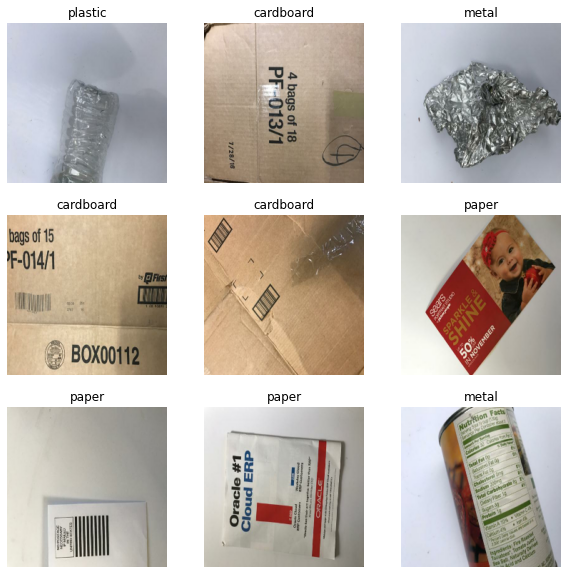

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
IMG_SHAPE = IMAGE_SHAPE + (3,)
feature_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor_layer = hub.KerasLayer(
    feature_model,
    input_shape=IMG_SHAPE,
    trainable=False) ## freezes layers with its pretrained weights


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomZoom(height_factor=(-0.05, 0.05)),
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.RandomTranslation(height_factor=0.2,width_factor=0.2),
    tf.keras.layers.GaussianNoise(0.01),
])

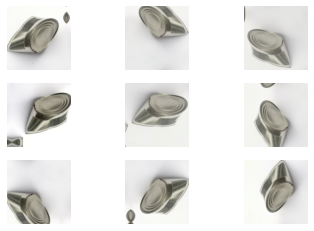

In [ ]:
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(images)
        plt.imshow(augmented_image[0])
        plt.axis("off")


In [ ]:
num_classes = 6
model = tf.keras.Sequential([
    data_augmentation,
    feature_extractor_layer,
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes) # changing top layer
])

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

Epoch 1/30
64/64 [==============================] - 179s 3s/step - loss: 0.9460 - accuracy: 0.6380 - val_loss: 0.7079 - val_accuracy: 0.7347
Epoch 2/30
64/64 [==============================] - 113s 2s/step - loss: 0.7445 - accuracy: 0.7196 - val_loss: 0.5957 - val_accuracy: 0.7703
Epoch 3/30
64/64 [==============================] - 117s 2s/step - loss: 0.6831 - accuracy: 0.7502 - val_loss: 0.5470 - val_accuracy: 0.8119
Epoch 4/30
64/64 [==============================] - 115s 2s/step - loss: 0.6359 - accuracy: 0.7646 - val_loss: 0.5154 - val_accuracy: 0.8218
Epoch 5/30
64/64 [==============================] - 114s 2s/step - loss: 0.5907 - accuracy: 0.7844 - val_loss: 0.4938 - val_accuracy: 0.8277
Epoch 6/30
64/64 [==============================] - 117s 2s/step - loss: 0.5477 - accuracy: 0.8037 - val_loss: 0.4818 - val_accuracy: 0.8436
Epoch 7/30
64/64 [==============================] - 120s 2s/step - loss: 0.5324 - accuracy: 0.8017 - val_loss: 0.4661 - val_accuracy: 0.8416
Epoch 8/30
64

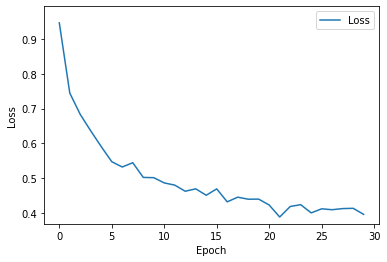

In [ ]:
learning_rate = 0.00001
epochs=30
batch_size = 64

history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size)

epochs = history.epoch
hist = pd.DataFrame(history.history)
loss = hist["loss"]

plot_the_loss_curve(epochs, loss)

In [ ]:
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
pred = []
for i in predictions:
    pred.append(np.argmax(i))

Predictions:
 [3, 2, 3, 3, 4, 4, 3, 2, 1, 5, 4, 4, 1, 3, 3, 3]
Labels:
 [3, 2, 3, 3, 4, 4, 3, 2, 1, 5, 4, 4, 1, 3, 4, 3]


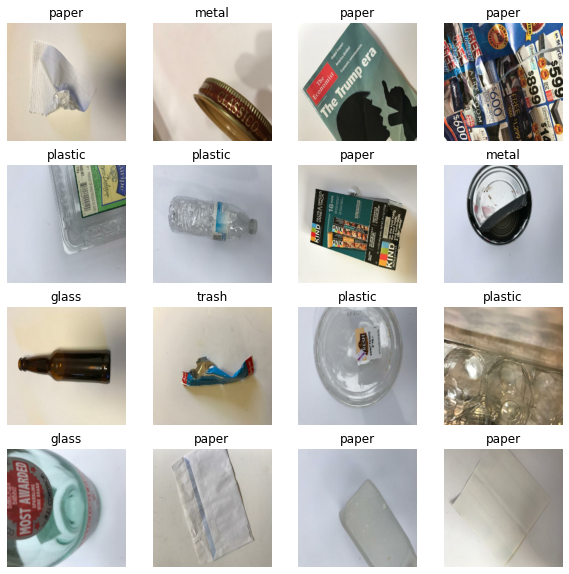

In [ ]:
print('Predictions:\n', pred)
print('Labels:\n', list(label_batch))

plt.figure(figsize=(10, 10))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[pred[i]])
    plt.axis("off")

In [ ]:
model.save('model_py/model.h5')

## TEST MODEL

In [ ]:
my_reloaded_model = tf.keras.models.load_model(('/content/drive/MyDrive/SUTD/rainer_model_py/model.h5'),custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
my_reloaded_model.save('rainer_model_py/graph_model_py/graph_model.h5')

Found 10 files belonging to 1 classes.
Predictions:
 [0, 3, 1, 4, 3, 1, 4, 3, 4, 4]


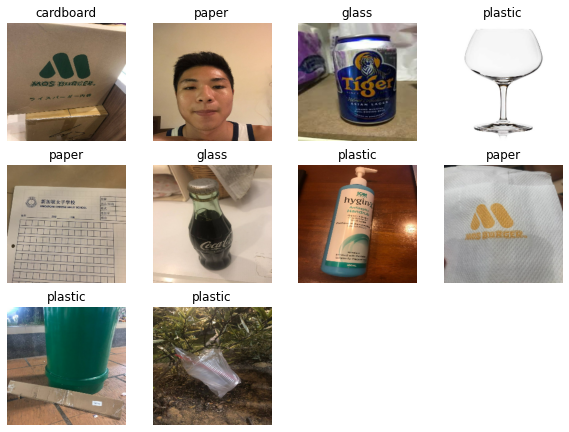

In [ ]:
class_names=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

path = '/content/drive/MyDrive/SUTD/rainer_model_py/unseen_test/'

imgs = tf.keras.utils.image_dataset_from_directory(
    path, labels=None, image_size=(224,
    224)
)

image_batch = imgs.as_numpy_iterator().next()
predictions = my_reloaded_model.predict_on_batch(image_batch)
pred = []
for i in predictions:
    pred.append(np.argmax(i))

print('Predictions:\n', pred)

plt.figure(figsize=(10, 10))
for i in range(len(pred)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[pred[i]])
    plt.axis("off")